#  Import Corresponding Packages

In [1]:
import numpy as np
import pandas as pd
import sympy
import pydotplus  # for substree plot
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import Image, display, Latex

In [2]:
from gplearn.genetic import SymbolicRegressor
from gplearn.functions import make_function
from gplearn.fitness import make_fitness
from sympy.plotting import plot as symplot 

In [3]:
import pickle # Save the program for later use, we have not used it here until now.

# Preprocesse Data

1. In this section, we are going to create two kinds of data, i.e., training dataset and test dataset. The $1^{st}$ one is for training symbolic regression network, the $2^{nd}$ one is to calculate the corresponding score of symbolic regression. While for the equation we are going to use is Eq. \ref{eq:Babbage's functional equation}. 
$$
f(x) = \frac{b-x}{1+cx}
\label{eq:Babbage's functional equation}
$$
where  $b$ and $c$ are arbitrary constants, which could be set by users.
By the way, Eq. \ref{eq:Babbage's functional equation} has to satisfy the constraints, i.e., 
$$
f(f(x)) = x
\label{eq:Babbage's constraint}
$$
2. In this python class, we also fit the data using `scipy`.

In [4]:
class FitData():
    def __init__(self):
        pass
    
    def fit_function(self, X, B, C):
        denominator = 1 + C * X
        numerator = B - X
        y =  numerator / denominator
        
        return y
    
    def fitdata(self, X, y):
        # X.squeeze() # If we do not do it, we would like to gain valueerror
        guess_normal = [0.4, 0.1]
        parameters, _ = curve_fit(self.fit_function, X.squeeze(), y, p0=guess_normal) 
        
        return parameters
    

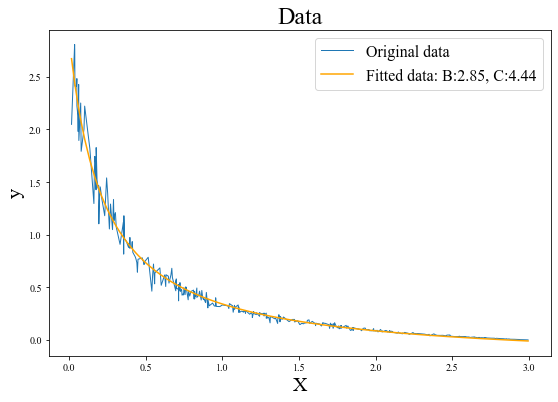

In [5]:
class PreData(FitData):
    """
    This is a class that constains all the functions to create the data.
    Variables:
    ---------------
        constant: dictionary
            The keys ('b' and 'c') are arbitrary constants for Baggages function.
            The values of respective keys are the value of arbitrary constants.
        number: int
            It is how much number of data we should create. The default value is
            500.
        ratio: float
            It is split ratio to create training dataset and test dataset. By the 
            way, in our code, we just use the simplest spliting mechanism. 
    Returns: numpy ndarray
    ---------------
        X_train； 400 * 1
        y_train： 400
    
    """
    def __init__(self, constant, number=500, ratio=0.8):
        super().__init__()
        self.b = constant['b']
        self.c = constant['c']
        self.number = number
        self.split_ratio = ratio
        self.font_dict = {'family':'Times New Roman', 'size': 20}
        self.title_dict = {'family':'Times New Roman', 'size': 24}
    
    def create_data(self):
        random_state = np.random.RandomState(0)  # Set random seed
        X = random_state.uniform(0, 3, self.number).reshape(-1, 1)
        numerator = self.b - X
        denominator = 1 + self.c * X
        y = numerator / denominator
        
        # Add noise to the data
        m, n = y.shape
        # noise = np.abs(random_state.randn(m, n))
        noise = random_state.randn(m, n)
        y_new = y * ( 1 + 0.1*noise)
        
        return X, y_new
#         return X, y

    def split_data(self, X, y):
        random_state = np.random.RandomState(0)

        num_sample, n_features = X.shape

        # Gain the mask
        chosen_index_list = []
        all_index = [i for i in range(num_sample)]
        index = 0
        while index < int(self.split_ratio * num_sample):
            chosen_index = random_state.choice(all_index, 1)
            if chosen_index not in chosen_index_list:
                chosen_index_list.append(chosen_index)
                index += 1

        # Extract the data
        X_train = X[chosen_index_list].reshape(-1, 1)
        y_train = y[chosen_index_list].reshape(-1, 1)

        # Gain test mask
        test_mask_list = []
        for num in all_index:
            if num not in chosen_index_list:
                test_mask_list.append(num)

        # Extract test data
        X_test = X[test_mask_list].reshape(-1, 1)
        y_test = y[test_mask_list].reshape(-1, 1)
        
        return X_train, y_train, X_test, y_test

    def sort_data(self, X, y):
        """
        X, y are numpy ndarray. We need to pay attention to sort function, 
        because it is one dimension here.
        """
        index = np.argsort(X, axis=0)
        X_new = X[index].reshape(-1, 1)
        y_new = y[index].reshape(-1, 1).squeeze()
        
        return X_new, y_new
        
    def plot_data(self, X, y, parameters):
        fit_data = self.fit_function(X, parameters[0], parameters[1])
        plt.rc('font',family='Times New Roman')  # Global font
        
        fig = plt.figure(figsize=(9, 6))
        plt.plot(X, y, label='Original data', linewidth=1)
        fit_label = 'Fitted data: B:{:.2f}, C:{:.2f}'.format(parameters[0], parameters[1])
        
        plt.plot(X, fit_data, label=fit_label, c='orange')
        plt.xlabel('X', fontdict=self.font_dict)
        plt.ylabel('y', fontdict=self.font_dict)
        plt.title('Data', fontdict=self.title_dict)
        plt.legend(fontsize=16)
        plt.show()
        
        return fit_data

    def run(self):
        # 1. Create data
        X, y = self.create_data()
        # 2. Split data
        X_train, y_train, X_test, y_test = self.split_data(X, y)
        # 3. Sort the data
        X_train, y_train = self.sort_data(X_train, y_train)
        X_test, y_test = self.sort_data(X_test, y_test)
        # 4. Fit data
        parameters = self.fitdata(X_train, y_train)
        # 4. Visualize the data
        fit_data = self.plot_data(X_train, y_train, parameters)
        
        return X_train, y_train, X_test, y_test, fit_data, parameters

arbitrary_const = {'b': 3, 'c': 5}
data_object = PreData(arbitrary_const)
X_train, y_train, X_test, y_test, fit_data, fit_parameters = data_object.run()

# Simple Symbolic Regression
## Base SR
1. Basic idea: Firstly, we develop a base symbolic regression class, then develop another one. But for the first one, we calculate the constraint as penalty in the self-made fitness function which would be put in the second class.
2. We found that, when stopping_criteria=0.02, generation_size=100, others remain unchanged, we could gain a solution even with a little large error.

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.70      1.77929e+12       12         0.080038        0.0758473     29.73m
   1    12.69          161.914       15        0.0443229        0.0439673      8.47m
-----------------------------------INFOMATION-----------------------------------
gplearn Expression  : div(sub(sub(-1.442, -5.189), div(X0, X0)), sub(div(X0, X0), mul(X0, -4.066)))
Symbolic Expression : 2.747/(4.066*X0 + 1)
Latex Expression    :--------------------


<IPython.core.display.Latex object>

Subtree Structure   :--------------------


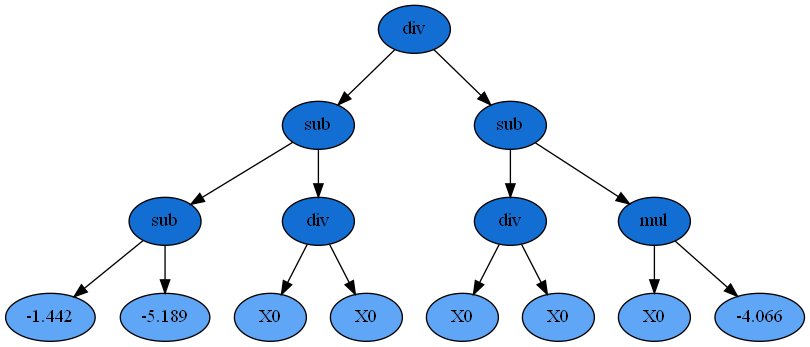

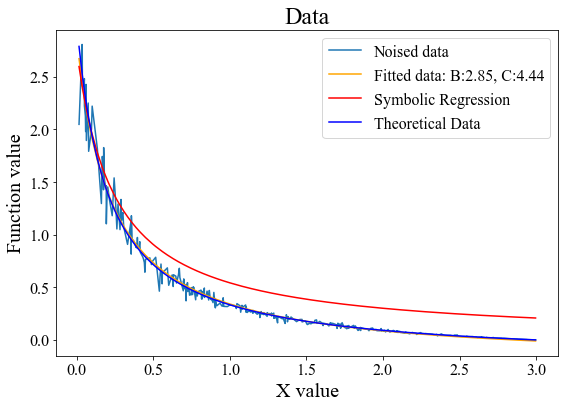

In [6]:
class BaseSymbolicRegression():
    """
    This is a self-made symbolic regressor that could achieve almost data analysis 
    task. 
    Note: All first SR instance variables we do not add '_' marker, but for the
        subSR, we use '_' marker to remain us when invoking variables.
    Variables:
        generation_size: int
            It is the generation sieze for the first SR instance.
        sub_generation_size: int
            It is the generation sieze for sub-SR instance which should be put
            in loop.
    """
    def __init__(self,
                 X,
                 y,
                 fit_data,
                 arbitrary_properties,
                 pop_size=1100,
                 generation_size=300,
                 stopping_criteria=0.00035,
                 const_limit=6,
                 warm_start=False):
        self.X_train = X
        self.y_train = y
        self.fit_data = fit_data['data']
        self.fit_parameters = fit_data['parameters']
        self.theo_parameters = arbitrary_properties
        self.population_size = pop_size
        self.generation_size = generation_size
        self.stopping_criteria = stopping_criteria
        self.const_limit = const_limit
        self.warm_start = warm_start  # :bool, optional (default=False)
        self.font_dict = {'family':'Times New Roman', 'size': 20}
        self.title_dict = {'family':'Times New Roman', 'size': 24}
    
    def create_func_set(self):
        fun_set = ('add', 'sub', 'mul', 'div', 'neg', 'abs')

        return fun_set

    def plot_graph(self, est_gp):
        """
        This is the function to plot the subtree structured individual
        Variables:
            est_gp: symbolic regressior after fitting
        """
        graph = est_gp._program.export_graphviz()
        graph = pydotplus.graphviz.graph_from_dot_data(graph)
        img = Image(graph.create_png())
        display(img)

    def print_information(self, est_gp):
        """
        This is the function to give final information after symbolic regression,
        and the esymbolic mathematical repression will be printed out.
        -----------
        Returns:
            next_e: A symbolic expression that could be used as a function,
                but we have to use sympy package to handle.
        """
        
        print('{:-^80}'.format('INFOMATION'))
        print("{:<20}:".format('gplearn Expression'), est_gp)
        next_e = self._get_next_estimation(est_gp)
        print("{:<20}:".format('Symbolic Expression'), next_e)

        # Latex expression
        print("{:<20}:{:-<20}".format('Latex Expression ', '-'))
        display(Latex(f"$${sympy.latex(next_e)}$$"))

        # Subtree-structure
        print("{:<20}:{:-<20}".format('Subtree Structure ', '-'))
        self.plot_graph(est_gp)

    def _get_next_estimation(self, est_gp):
        converter = {
            'sub': lambda x, y: x - y,
            'div': lambda x, y: x / y,
            'mul': lambda x, y: x * y,
            'add': lambda x, y: x + y,
            'neg': lambda x: -x,
            'abs': lambda x: sympy.Abs(x),
            'pow': lambda x, y: x**y, 
            'sin': lambda x: sympy.sin(x),
            'cos': lambda x: sympy.cos(x),
            'inv': lambda x: 1 / x,
            'sqrt': lambda x: x**0.5,
            'self_exp': lambda x: sympy.exp(x**2),
            'square': lambda x: x**2
        }  # Converter set
        next_e = sympy.sympify(str(est_gp._program), locals=converter)
        
        return next_e
    
    def cal_sr_data(self, next_e):
        
        X0 = sympy.symbols('X0')  # Create the symbols object
        x_scale_list = X_train.squeeze().tolist() # data dimension problem
        est_value = [next_e.subs({X0: value}) for value in x_scale_list]
        est_value = np.array(est_value)
        
        return est_value

    def cal_theo_data(self):
        B = self.theo_parameters['b']
        C = self.theo_parameters['c']
        denominator = 1 + C * self.X_train
        numerator = B - self.X_train
        y = numerator / denominator

        return y

    def plot_comprison(self, next_e):
        plt.rc('font', family='Times New Roman')  # Global font

        fig = plt.figure(figsize=(9, 6))
        # Plot data
        plt.plot(self.X_train,
                 self.y_train,
                 label='Noised data',
                 linewidth=1.5)
        fit_label = 'Fitted data: B:{:.2f}, C:{:.2f}'.format(
            self.fit_parameters[0], self.fit_parameters[1])
        plt.plot(self.X_train, self.fit_data, label=fit_label, c='orange')
        est_value = self.cal_sr_data(next_e)
        # print(est_value)
        plt.plot(self.X_train, est_value, label='Symbolic Regression', c='red')
        theo_data = self.cal_theo_data()
        plt.plot(self.X_train, theo_data, label='Theoretical Data', c='b')

        # Axes control
        plt.xlabel('X value', fontdict=self.font_dict)
        plt.xticks(fontsize=16)
        plt.ylabel('Function value', fontdict=self.font_dict)
        plt.yticks(fontsize=16)
        plt.title('Data', fontdict=self.title_dict)
        plt.legend(fontsize=16)

        plt.show()
    
    def fit_sr_data(self):
        """
        Returns:
        -----------
            est_gp: Only this return variable could use set_params function so
                that the evolution will continue.
        """
        est_gp = SymbolicRegressor(population_size=self.population_size,
                                   function_set=self.create_func_set(),
                                   generations=self.generation_size,
                                   stopping_criteria=self.stopping_criteria,
                                   const_range=(-self.const_limit,
                                                self.const_limit),
                                   p_crossover=0.7,
                                   p_subtree_mutation=0.1,
                                   p_hoist_mutation=0.05,
                                   p_point_mutation=0.1,
                                   max_samples=0.9,
                                   verbose=1,
                                   metric='mse',
                                   parsimony_coefficient=0.01,
                                   random_state=0,
                                   n_jobs=2,
                                   warm_start=False,
                                   low_memory=True)

        est_gp.fit(self.X_train,
                   self.y_train)  # X should be 2-D, y should be 1-D

        return est_gp

    def run(self):
        # Fit data
        est_gp = self.fit_sr_data()
        # Give symbolic expression
        next_e = self._get_next_estimation(est_gp)
        self.print_information(est_gp)
        # Plot comparison
        self.plot_comprison(next_e)
        
        return next_e, est_gp


fit_data_dict = {'data': fit_data, 'parameters': fit_parameters}
baseSR_object = BaseSymbolicRegression(X=X_train,
                                       y=y_train,
                                       fit_data=fit_data_dict,
                                       arbitrary_properties=arbitrary_const,
                                       generation_size=1000,
                                       stopping_criteria=0.05)
next_e, est_gp = baseSR_object.run()

## Advanced SR
1. BTW, we could create `@staticmethod` in a class so that the self property would not be used.
2. While using warm_start property, we need to know that the generation size in `set_params()` should be the summation of former size and nest generation size. Then the `fit` function of the instance should be used.

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.70      1.77929e+12       12         0.080038        0.0758473      4.13s
   1    12.69          161.914       15        0.0443229        0.0439673      4.12s
   2     8.11           375.59       15        0.0172723        0.0156777      3.50s
   3    11.10          204.828       15        0.0165741        0.0219618      3.09s
   4    12.66          66.2294       15        0.0152637         0.038677      2.57s
   5    13.33          1323.69       21       0.00676233       0.00104285      2.17s
   6    11.66          11124.2       19       0.00984904       0.00543891      1.72s
   7    10.33           46.474       16        0.0151815        0.0686684      1.13s
   8     9.79          33.8638       19        0.0141384        0.0350179  

<IPython.core.display.Latex object>

Subtree Structure   :--------------------


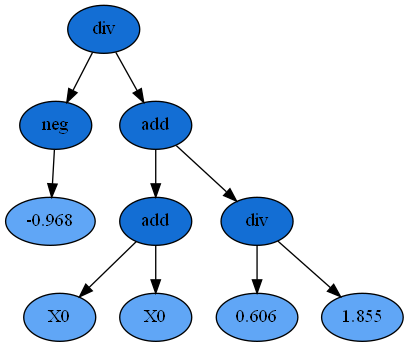

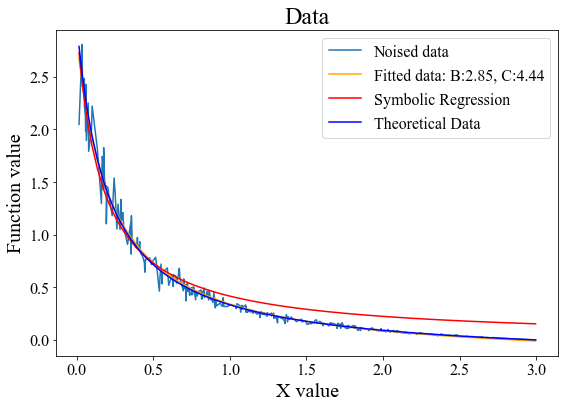

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  10     9.93          19.0394       10        0.0154318        0.0270931     10.16s
  11    10.00          42.6986       10         0.015426        0.0271452     10.14s
  12    10.05          31.8517       10        0.0151787        0.0263382      9.56s
  13     9.98          17.9807       10        0.0151785        0.0263397      8.71s
  14     9.88          54.4633       10        0.0142086        0.0350689      9.43s
  15    10.20            58746       10        0.0145217        0.0322504      7.37s
  16     9.94           133.22       10        0.0147398        0.0302881      6.89s
  17     9.93          430.732       10        0.0143162        0.0341007      6.68s
  18     9.74          130.512       10        0.0143339        0.0311855  

<IPython.core.display.Latex object>

Subtree Structure   :--------------------


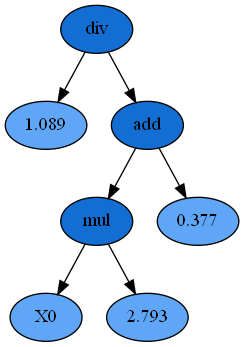

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  30     7.11          56.3151        7        0.0156696        0.0422703      9.49s
  31     7.09          100.961        7        0.0157131        0.0418788      9.23s
  32     7.04           40.726        7        0.0164822        0.0349566     10.47s
  33     7.02          52.1494        7        0.0159046        0.0401548      8.25s
  34     7.15          64.4368        7        0.0162475        0.0370694      7.19s
  35     6.97          298.374        7        0.0150587        0.0477686      6.97s
  36     7.23          33.2319        7        0.0163793        0.0358827      6.76s
  37     7.05          36.6568        7         0.016168        0.0377841      5.90s
  38     7.17          192.624        7        0.0158143        0.0409682  

<IPython.core.display.Latex object>

Subtree Structure   :--------------------


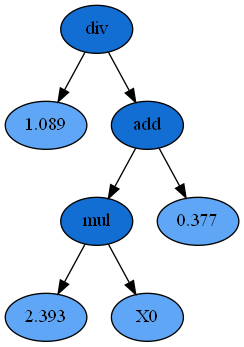

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  50     7.03          17.8847        7        0.0152675         0.031722     11.22s
  51     7.25          54.2138        7        0.0152056        0.0322794      9.85s
  52     7.05           173970        7           0.0151         0.033229      8.34s
  53     7.02          22.8701        7        0.0153773        0.0307338      7.96s
  54     6.99          28.8385        7        0.0151962        0.0323637      7.62s
  55     6.93          31.3798        7        0.0150308        0.0338521      6.94s
  56     7.17          298.935        7        0.0152128         0.032214      6.39s
  57     7.03          14.2402        7        0.0149614        0.0344765      7.02s
  58     7.12          190.812        7        0.0149436        0.0346367  

<IPython.core.display.Latex object>

Subtree Structure   :--------------------


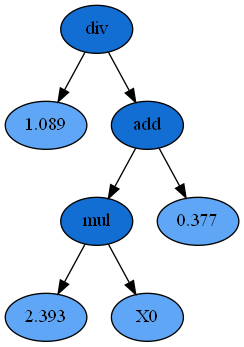

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  70     7.14          164.424        7        0.0152985        0.0314425      9.43s
  71     6.77          53.2204        7        0.0149171        0.0348751      8.62s
  72     7.08          302.932        7        0.0147771        0.0361354      8.77s
  73     7.00          332.036        7        0.0152787        0.0316208      7.91s
  74     7.15          246.982        7         0.015011        0.0340304      7.50s
  75     7.07          18.2186        7        0.0154845        0.0297689      7.16s
  76     7.04          27.7304        7        0.0150523        0.0336588      7.07s
  77     6.83          32.7999        7        0.0153203        0.0312465      6.08s
  78     6.93          18.6624        7        0.0152796        0.0316131  

<IPython.core.display.Latex object>

Subtree Structure   :--------------------


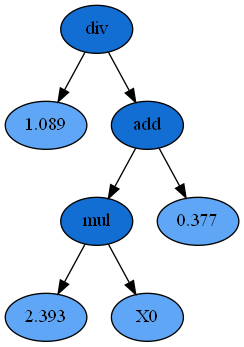

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  90     7.33           38.022        7           0.0149        0.0350292      9.58s
  91     6.88          38.0984        7        0.0152799        0.0316101      8.88s
  92     7.02          17209.1        7         0.015148        0.0327972      8.58s
  93     6.96          44.3884        7        0.0145392        0.0382768      8.27s
  94     7.02          28.3971        7        0.0152509        0.0318711      8.13s
  95     7.11           23.377        7        0.0153885        0.0306326      7.24s
  96     6.97           34.513        7        0.0143731        0.0397717      6.41s
  97     6.93          34.1526        7         0.015282        0.0315916      5.91s
  98     7.28          93.4145        7        0.0144766        0.0388398  

<IPython.core.display.Latex object>

Subtree Structure   :--------------------


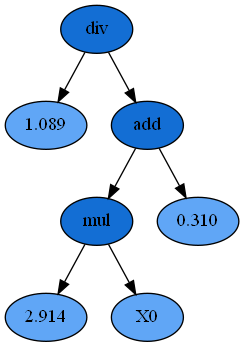

[0.08003795689370402, 0.04432293282581949, 0.017272337692535604, 0.01657410729227172, 0.015263687950610024, 0.006762332119692717, 0.009849042192428907, 0.015181473707066072, 0.014138424778476268, 0.016265102243318973, 0.01543177882034943, 0.015425992996261583, 0.015178658580590337, 0.01517849229709591, 0.014208577507896603, 0.014521745993436221, 0.014739771627856188, 0.014316158292175642, 0.014333905810341994, 0.014646777803974907, 0.014176379244711542, 0.01475150747907783, 0.014500935387383168, 0.011939546190964073, 0.014713998512578742, 0.018390206547347392, 0.018103336869328742, 0.01735534637373235, 0.017837231589964798, 0.017135470257729244, 0.01566957448424766, 0.015713072260453362, 0.016482208578616854, 0.015904632974431867, 0.016247459990512848, 0.015058653778797308, 0.016379314829732202, 0.016168044404832237, 0.0158142557771087, 0.015993603858717145, 0.0158878754738414, 0.01548607057765738, 0.01482098580704902, 0.015233453231551562, 0.015230158182641205, 0.01484953693447077, 0.

In [7]:
class Penalty():
    """This class is to store the error we calculated"""
    error_list = [0]


class AdvancedSR():
    def __init__(self, X, y, sub_generation=10, norm_coefficient=0.01):
        self.X_train_ = X
        self.y_train_ = y
        self.sub_generation_ = sub_generation
        self.L2_norm_coeff_  =  norm_coefficient

    @staticmethod
    def _mape(y, y_pred, w):
        """Calculate the mean absolute percentage error."""
        diffs = np.abs(
            np.divide((np.maximum(0.001, y) - np.maximum(0.001, y_pred)),
                      np.maximum(0.001, y)))

        return 100. * np.average(diffs, weights=w)

    @staticmethod
    def _mean_square_error(y, y_pred, w):
        """Calculate the mean square error."""
        mse_origin = np.average(((y_pred - y)**2), weights=w)
        mse_modified = mse_origin

        # print('MSE modified', mse_modified)
        return mse_modified

    def _cal_error(self, sym_espression):
        """This is a function to calculate the constraint."""
        X0 = sympy.symbols('X0')  # Create the symbols object
        x_scale_list = X_train.squeeze().tolist()  # data dimension problem
        f_x = [sym_espression.subs({X0: value}) for value in x_scale_list]
        #         f_x = np.array(f_x)
        f_x_x = [sym_espression.subs({X0: value}) for value in f_x]
        f_x_x = np.array(f_x_x)  # (400, )

        error = f_x_x - X_train.squeeze()  # the dtype of error is object
        error = np.array(error, dtype=float)  # change the dtype
        # mask = pd.isnull(error)
        try:
            # error = np.abs(error.max())  # we use positive value here
            error = np.average(error**2) * self.L2_norm_coeff_
        except:
            raise ('Nan in error object')
        # finally:
            
        return np.round_(error, 6)

    def _create_self_fitness(self):
        mape = make_fitness(AdvancedSR._mape, greater_is_better=False)
        mse = make_fitness(AdvancedSR._mean_square_error,
                           greater_is_better=False)

        # print('Fitness function made!')
        return mape, mse

    def run(self):
        # this is global parameter, should be modified.
        fit_data_dict = {'data': fit_data, 'parameters': fit_parameters}
        # Create baseSR instance
        baseSR_object = BaseSymbolicRegression(
            X=self.X_train_,
            y=self.y_train_,
            fit_data=fit_data_dict,
            arbitrary_properties=arbitrary_const,
            generation_size=10,
            stopping_criteria=0.001)
        next_e, est_gp = baseSR_object.run() # Give first sub-generation result
        # Calculate the constraint
        L2_norm = self._cal_error(next_e)
        Penalty.error_list.append(L2_norm)  # add error to the Penalty

        iteration_number = 0
        while iteration_number < 1:
            # Use warm_start property to continue evolving
            sub_mape, sub_mse = self._create_self_fitness(
            )  # Obatin self-made fitness function
            est_gp = est_gp.set_params(generations=self.sub_generation_,
                                       warm_start=True)
                                       #metric=sub_mse)  # Continue envolving
            next_e = baseSR_object._get_next_estimation(est_gp)
            
            L2_norm = self._cal_error(next_e)
            if L2_norm == Penalty.error_list[-1]:
                L2_norm = L2_norm * 0.9
            Penalty.error_list.append(L2_norm)  # add error to the Penalty
            
            #if (iteration_number % 10 == 0) and (iteration_number != 0): 
            baseSR_object.print_information(
                est_gp
            )  # Get symbolic expression (i.e., f(x)) at this time and print information

            print(est_gp.run_details_['best_fitness'])
            # print("THe fitness of the last one is ", est_gp._program.fitness_)
            iteration_number += 1

        return next_e, est_gp

    def fake_run(self):
        """
        In this section, we are going to test whether warm_start works 
        if we add self-made fitness function!
        -------------
        1. Test the code using warm_start without self-made fitness funcion.
        2. Create the other function to test if the self-made fitness function works.
        """
        # this is global parameter, should be modified.
        fit_data_dict = {'data': fit_data, 'parameters': fit_parameters}
        # 1. Create baseSR instance: first 10 generations
        baseSR_object = BaseSymbolicRegression(
            X=self.X_train_,
            y=self.y_train_,
            fit_data=fit_data_dict,
            arbitrary_properties=arbitrary_const,
            generation_size=10,
            stopping_criteria=0.001)
        next_e, est_gp = baseSR_object.run(
        )  # Give first sub-generation result
        
        # 2. Calculate L2-Norm and create new fitness function
        # Error calculation
        L2_norm = self._cal_error(next_e)
        Penalty.error_list.append(L2_norm) # add error to the Penalty
            
        iteration_num = 0
        while iteration_num < 5:
            # 3. Then later 10 generations
            iter_gene_size = 10 + 2*(iteration_num+1)*self.sub_generation_ 
            # New fitness function creation with L2-Norm
            sub_mape, sub_mse = self._create_self_fitness()
            est_gp.set_params(generations=iter_gene_size, metric=sub_mse, warm_start=True)
            # fit the function.
            est_gp.fit(self.X_train_, self.y_train_)

            next_e = baseSR_object._get_next_estimation(est_gp)
            baseSR_object.print_information(
                    est_gp
                )  # Get symbolic expression (i.e., f(x)) at this time and print information
            
            # Calculate the error
            L2_norm = self._cal_error(next_e)
            Penalty.error_list.append(L2_norm)
            
            iteration_num += 1
            
        print(est_gp.run_details_['best_fitness']) # This constains all the fitness values in est_gp

        return next_e, est_gp

    
advancedSR_object = AdvancedSR(X=X_train, y=y_train)
next_e, est_gp = advancedSR_object.fake_run()

In [8]:
5 != 5

False

In [9]:
Penalty.error_list

[0, 0.004873, 0.005116, 0.005047, 0.005047, 0.005047, 0.00408]

In [10]:




# Use warm_start property to continue evolving
sub_mape, sub_mse = _create_self_fitness()  # Obatin self-made fitness function
est_gp = est_gp.set_params(generations=50, warm_start=True,
                           metric=sub_mse)  # Continue envolving
sym_espression = baseSR_object.print_information(
    est_gp
)  # Get symbolic expression (i.e., f(x)) at this time and print information




NameError: name '_create_self_fitness' is not defined

In [ ]:
class Example():
    data = []
    
Example.data.append(1)
Example.data[-1]

In [ ]:
sym_espression = baseSR_object.print_information(est_gp)